In [ ]:
!pip install webrtcvad pydiarization matplotlib==3.1.3
!git clone https://github.com/josepatino/pyBK.git
%cd pyBK

     |████████████████████████████████| 66 kB 2.5 MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72385 sha256=c6c9f3d470b1a1973fc23e478a4ef8803654b3428279085b744be0a5b272787e
  Stored in directory: /root/.cache/pip/wheels/11/f9/67/a3158d131f57e1c0a7d8d966a707d4a2fb27567a4fe47723ad
Successfully built webrtcvad


In [ ]:
!python main.py 

In [ ]:
from pydiarization.diarization_wrapper import rttm_to_string
import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class ReformatAudio:
    def __init__(self, formatting_type='masking'):
        self.formatting_type = formatting_type
        self.combined_wav = '/content/5/combined.wav'
        self.threshold = 0.1
        assert formatting_type in ['masking', 'combining']

    def to_melspec(self, audio):
        y, sr = librosa.load(audio)
        frame_length = 0.025
        frame_stride = 0.010
        input_nfft = int(round(sr*frame_length))
        input_stride = int(round(sr*frame_stride))
        frame_length = input_nfft/sr
        mel_spec = librosa.feature.melspectrogram(y=y, n_mels=128, n_fft=input_nfft, hop_length=input_stride)
        return mel_spec, input_stride

    def show(self, audio=None, mel_spec=None):
        if audio!=None:
            mel_spec, input_stride = self.to_melspec(audio)
        assert len(mel_spec)>0
        plt.figure(figsize=(10, 4))
        specshow(librosa.power_to_db(mel_spec, ref=np.max), y_axis='mel', x_axis='time')
        plt.tight_layout()
        plt.show()

    def time_mask(self, audio, rttm_file):
        x, _ = self.to_melspec(audio)
        diars = rttm_to_string(rttm_file).split('\n')
        doctor = diars[0].split()[-2]
        for diar in diars[:-1]:
            diar = diar.split()
            timestamp, duration = int(float(diar[3])*100), int(float(diar[4])*100)
            if diar[-2]==doctor or duration<self.threshold: 
                x[:, timestamp:timestamp+duration] = 0
        self.show(mel_spec=x)
        return x

    def chunk_combine_audio(self, audio, rttm_file):
        import wave
        x, _ = self.to_melspec(audio)
        diars = rttm_to_string(rttm_file).split('\n')
        selected_data = []
        for ind, diar in enumerate(diars[:-1]):
            diar = diar.split()
            doctor = diars[0].split()[-2]
            timestamp, duration = int(float(diar[3])), int(float(diar[4]))
            if diar[-2]==doctor or duration<self.threshold: 
                continue
            with wave.open(audio, "rb") as infile:
                nchannels = infile.getnchannels()
                sampwidth = infile.getsampwidth()
                framerate = infile.getframerate()
                infile.setpos(int(timestamp * framerate))
                data = infile.readframes(int((duration) * framerate))
                selected_data.append(data)
    
        with wave.open(self.combined_wav, 'w') as outfile:
            outfile.setnchannels(nchannels)
            outfile.setsampwidth(sampwidth)
            outfile.setframerate(framerate)
            for i in range(len(selected_data)):
                outfile.writeframes(selected_data[i])
        mel_spec, _ = self.to_melspec(self.combined_wav)
        return mel_spec

            
    def reformat(self, audio, rttm_file):
        if self.formatting_type=='masking': 
            return self.time_mask(audio, rttm_file)
        else:
            return self.chunk_combine_audio(audio, rttm_file)



In [ ]:
audio = "/content/5/nc-cu-0802-0-5-v.wav"
rttm_file = "/content/5/results.rttm"

In [ ]:
rf = ReformatAudio('combining')
m_spec = rf.reformat(audio, rttm_file)

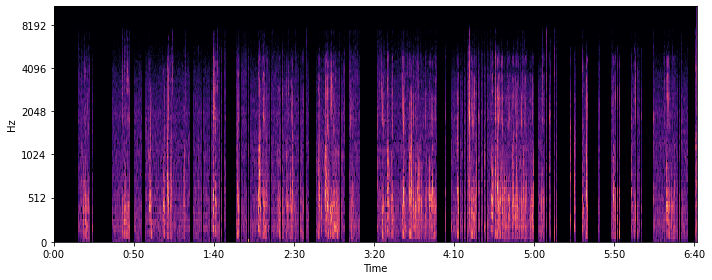

In [ ]:
rf = ReformatAudio('masking')
masked_spec = rf.reformat(audio, rttm_file)